## Objective: use decision tree to improve the performance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 4

### Load train and test data

In [2]:
train_data = pd.read_csv('./data/train_data.csv', parse_dates=['date_act', 'date_ppl'])
test_data = pd.read_csv('./data/test_data.csv', parse_dates=['date_act', 'date_ppl'])
print train_data.shape, test_data.shape

(2153346, 55) (498687, 54)


### Concatenate train and test data for preprocessing

In [39]:
meta_cols = dict() # contain the column types
col_types = train_data.dtypes 

In [40]:
meta_cols['bool'] = list(col_types[col_types=='bool'].index)
meta_cols['numeric'] = list(col_types[col_types=='int64'].index.drop('outcome'))
meta_cols['datetime'] = list(col_types[col_types=='datetime64[ns]'].index)
meta_cols['index'] = list(col_types[col_types=='object'].index)
meta_cols['label'] = ['outcome']

In [41]:
meta_cols

{'bool': ['char_10_ppl',
  'char_11',
  'char_12',
  'char_13',
  'char_14',
  'char_15',
  'char_16',
  'char_17',
  'char_18',
  'char_19',
  'char_20',
  'char_21',
  'char_22',
  'char_23',
  'char_24',
  'char_25',
  'char_26',
  'char_27',
  'char_28',
  'char_29',
  'char_30',
  'char_31',
  'char_32',
  'char_33',
  'char_34',
  'char_35',
  'char_36',
  'char_37'],
 'datetime': ['date_act', 'date_ppl'],
 'index': ['people_id', 'activity_id'],
 'label': ['outcome'],
 'numeric': ['activity_category',
  'char_1_act',
  'char_2_act',
  'char_3_act',
  'char_4_act',
  'char_5_act',
  'char_6_act',
  'char_7_act',
  'char_8_act',
  'char_9_act',
  'char_10_act',
  'char_1_ppl',
  'group_1',
  'char_2_ppl',
  'char_3_ppl',
  'char_4_ppl',
  'char_5_ppl',
  'char_6_ppl',
  'char_7_ppl',
  'char_8_ppl',
  'char_9_ppl',
  'char_38']}

In [42]:
full_data = pd.concat([
                    train_data[meta_cols['index'] + meta_cols['datetime'] + meta_cols['numeric'] + meta_cols['bool'] + meta_cols['label']]
                    , test_data[meta_cols['index'] + meta_cols['datetime'] + meta_cols['numeric'] + meta_cols['bool']]
                      ])

### Transform bool vales into binary 0 or 1

In [43]:
for col in meta_cols['bool']:
    print 'bool 2 binary : {}'.format(col)
    full_data[col] = full_data[col].apply(lambda x : int(x == True))
    print '-------------------------------'
print 'transformation is completed... ...'

bool 2 binary : char_10_ppl
-------------------------------
bool 2 binary : char_11
-------------------------------
bool 2 binary : char_12
-------------------------------
bool 2 binary : char_13
-------------------------------
bool 2 binary : char_14
-------------------------------
bool 2 binary : char_15
-------------------------------
bool 2 binary : char_16
-------------------------------
bool 2 binary : char_17
-------------------------------
bool 2 binary : char_18
-------------------------------
bool 2 binary : char_19
-------------------------------
bool 2 binary : char_20
-------------------------------
bool 2 binary : char_21
-------------------------------
bool 2 binary : char_22
-------------------------------
bool 2 binary : char_23
-------------------------------
bool 2 binary : char_24
-------------------------------
bool 2 binary : char_25
-------------------------------
bool 2 binary : char_26
-------------------------------
bool 2 binary : char_27
--------------------

In [45]:
meta_cols['numeric'] = meta_cols['numeric'] + meta_cols['bool']
meta_cols.pop('bool', None)
meta_cols.keys()

['index', 'label', 'numeric', 'datetime']

### Add year, month, week, day, dayofweek from datetime features

In [46]:
full_data['date_act_year'] = full_data.date_act.dt.year
full_data['date_act_month'] = full_data.date_act.dt.month
full_data['date_act_week'] = full_data.date_act.dt.week
full_data['date_act_day'] = full_data.date_act.dt.day
full_data['date_act_dayofweek'] = full_data.date_act.dt.dayofweek

In [47]:
full_data['date_ppl_year'] = full_data.date_ppl.dt.year
full_data['date_ppl_month'] = full_data.date_ppl.dt.month
full_data['date_ppl_week'] = full_data.date_ppl.dt.week
full_data['date_ppl_day'] = full_data.date_ppl.dt.day
full_data['date_ppl_dayofweek'] = full_data.date_ppl.dt.dayofweek

In [48]:
# drop the raw date
full_data.drop(['date_act', 'date_ppl'], axis=1, inplace=True)

In [49]:
meta_cols['datetime'] = ['date_act_year', 'date_act_month', 'date_act_week', 'date_act_day', 'date_act_dayofweek', 'date_ppl_year', 'date_ppl_month', 'date_ppl_week', 'date_ppl_day', 'date_ppl_dayofweek']

In [50]:
meta_cols['datetime']

['date_act_year',
 'date_act_month',
 'date_act_week',
 'date_act_day',
 'date_act_dayofweek',
 'date_ppl_year',
 'date_ppl_month',
 'date_ppl_week',
 'date_ppl_day',
 'date_ppl_dayofweek']

In [51]:
meta_cols.keys()

['index', 'label', 'numeric', 'datetime']

### split out the train and test data

In [52]:
train_data = full_data.iloc[:len(train_data)]
test_data = full_data.iloc[len(train_data):]

In [54]:
print train_data.shape, test_data.shape

(2153346, 63) (498687, 63)


In [56]:
train_data.outcome.tail()

2153341    1.0
2153342    1.0
2153343    1.0
2153344    1.0
2153345    1.0
Name: outcome, dtype: float64

In [57]:
test_data.outcome.head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: outcome, dtype: float64

In [58]:
# write out the data set ready for modeling
train_data.to_csv('./data/train_data2.csv', index=False)
test_data.to_csv('./data/test_data2.csv', index=False) 

### Decision Tree Classification

In [99]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.cross_validation import cross_val_score
import time

In [81]:
predictors = meta_cols['numeric'] + meta_cols['datetime']
label = meta_cols['label']

In [120]:
def model_fit(estimator, train_data, predictors, label, cv=True, cv_folds=3):
    """template to fit model and output score(accuracy and roc_auc), feature importance, and running time
    label: need to be string
    """
    start_time = time.time()
    # fit the model on the train data
    estimator.fit(train_data[predictors], train_data[label])
        
    # predict train data
    preds = estimator.predict(train_data[predictors])
    preds_proba = estimator.predict_proba(train_data[predictors])[:,1]
    
    # if true, perform cross-validation:
    if cv:
        cv_score = cross_val_score(estimator, train_data[predictors], train_data[label], cv=cv_folds, scoring='roc_auc')
    
    # report scores
    print "\nModel Scores:"
    print "Accuracy : {:.7f}".format(accuracy_score(train_data[label].values, preds))
    print "AUC Score (Train): {:.7f}".format(roc_auc_score(train_data[label], preds_proba))
    
    if cv:
        print "CV Scores : Mean - {:.7f} | Std - {:.7f} | Min - {:.7f} | Max - {:.7f}".format(np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
        
    # report feature importance
    feature_importance = pd.Series(estimator.feature_importances_, predictors).sort_values(ascending=False)
    feature_importance.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
        
    # report running time
    print "--- {} seconds ---".format(time.time() - start_time)


Model Scores:
Accuracy : 1.0000000
AUC Score (Train): 1.0000000
CV Scores : Mean - 0.8291524 | Std - 0.0267254 | Min - 0.7913967 | Max - 0.8495318
--- 98.6898400784 seconds ---


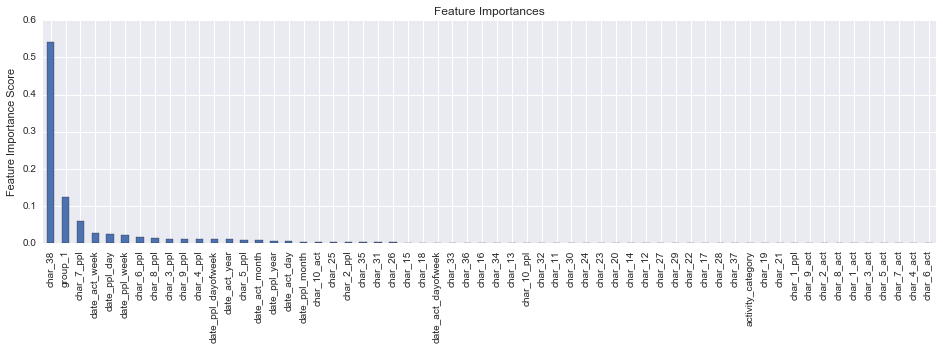

In [122]:
clf = DecisionTreeClassifier(random_state=1234)
model_fit(clf, train_data, predictors, label[0])

- There is apparent overfitting in the train set prediction.
- CV scores of decision tree improved from 0.56 to 0.83
- 'char_38', 'group_1', and 'char_7_ppl' are top 3 featrues

### In the next stage, we continue to improve the performance using Random Forest and Gradient Boosting